# Image Classification using PyTorch & AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [91]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install -U sagemaker

In [92]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import matplotlib.pyplot as plt
import os
from PIL import Image
import io
from os import listdir
import IPython
from IPython.display import Image as ImageDisplay
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.serializers import IdentitySerializer
from sagemaker.debugger import Rule, ProfilerRule, rule_configs,DebuggerHookConfig,ProfilerConfig, FrameworkProfile
from mpl_toolkits.axes_grid1 import host_subplot
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [93]:
print(f"Default Bucket: {bucket}")
print(f"RoleArn: {role}")

Default Bucket: sagemaker-us-east-1-476045913561
RoleArn: arn:aws:iam::476045913561:role/service-role/AmazonSageMaker-ExecutionRole-20240913T135670


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [6]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-09-21 15:58:59--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.200, 52.219.117.168, 52.219.112.208, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  40.2MB/s    in 35s     

2024-09-21 15:59:37 (31.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.j

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [82]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("default_bucket: {}".format(bucket))

region = session.boto_region_name
print("boto_region_name: {}".format(region))

role = sagemaker.get_execution_role()
print("execution_role: {}".format(role))

default_bucket: sagemaker-us-east-1-476045913561
boto_region_name: us-east-1
execution_role: arn:aws:iam::476045913561:role/service-role/AmazonSageMaker-ExecutionRole-20240913T135670


In [8]:
!aws s3 cp --recursive --quiet ./dogImages 's3://sagemaker-us-east-1-476045913561/'

In [15]:
# Declare HP ranges and metrics
hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([16, 32, 64, 128, 256]),
    "epochs": sagemaker.tuner.IntegerParameter(2, 5)
}

obj_metric_name = "accuracy"
obj_type = "Maximize"
metric_def = [{"Name": "accuracy", "Regex": "\((\d+)%\)"}]

In [21]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator = estimator,
    metric_definitions = metric_def,
    objective_metric_name = obj_metric_name,
    objective_type = obj_type,
    max_jobs = 4,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [33]:
train = f"s3://{bucket}/dogImages/train"
print(train)
valid = f"s3://{bucket}/dogImages/valid"
print(valid)

s3://sagemaker-us-east-1-476045913561/dogImages/train
s3://sagemaker-us-east-1-476045913561/dogImages/valid


In [35]:
# TODO: Fit your HP Tuner
tuner.fit({"train": train, "test": valid})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [43]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-09-21 18:12:50 Starting - Found matching resource for reuse
2024-09-21 18:12:50 Downloading - Downloading the training image
2024-09-21 18:12:50 Training - Training image download completed. Training in progress.
2024-09-21 18:12:50 Uploading - Uploading generated training model
2024-09-21 18:12:50 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"accuracy"',
 'batch-size': '"256"',
 'epochs': '4',
 'lr': '0.019652379348016058',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-09-21-17-13-13-538"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-17-13-13-538/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [45]:
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "5", 
                     "eval.save_interval": "1"
                    }
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [46]:
new_hyperparameters = {
    "batch-size": "256",
    "epochs": 4,
    "lr": "0.019652379348016058",
}

In [47]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    source_dir=".",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=new_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({"train": train, "test": valid}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-09-21-18-30-14-961


2024-09-21 18:33:03 Starting - Starting the training job...
2024-09-21 18:33:29 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-09-21 18:34:06 Downloading - Downloading input data...
2024-09-21 18:34:29 Downloading - Downloading the training image...
2024-09-21 18:35:06 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-09-21 18:35:07,192 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-09-21 18:35:07,195 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-21 18:35:07,205 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-09-21 18:35:07,207 sagemaker_pytorch_container.training INFO     Invoking user training script

In [148]:
#Runs, but issues come on my end of things. Code works.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

AttributeError: 'PyTorchModel' object has no attribute 'latest_job_debugger_artifacts_path'

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [95]:
"""tensorboard_output_path=trial
print(tensorboard_output_path)
!aws s3 ls {tensorboard_output_path}/"""

'tensorboard_output_path=trial\nprint(tensorboard_output_path)\n!aws s3 ls {tensorboard_output_path}/'

In [96]:
def get_inf(trial, name, t_mode):
    tensor = trial.tensor(name)
    steps = tensor.steps(mode=t_mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=t_mode))
    return steps, vals

In [97]:
def plt_ten(trial, name):
    s_train, vals_train = get_inf(trial, name, t_mode=ModeKeys.TRAIN)
    s_valid, vals_eval = get_inf(trial, name, t_mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(name)

    (p1,) = host.plot(s_train, vals_train, label=name)
    (p2,) = par.plot(s_valid, vals_eval, label="val_" + name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(name)
    
    plt.show()

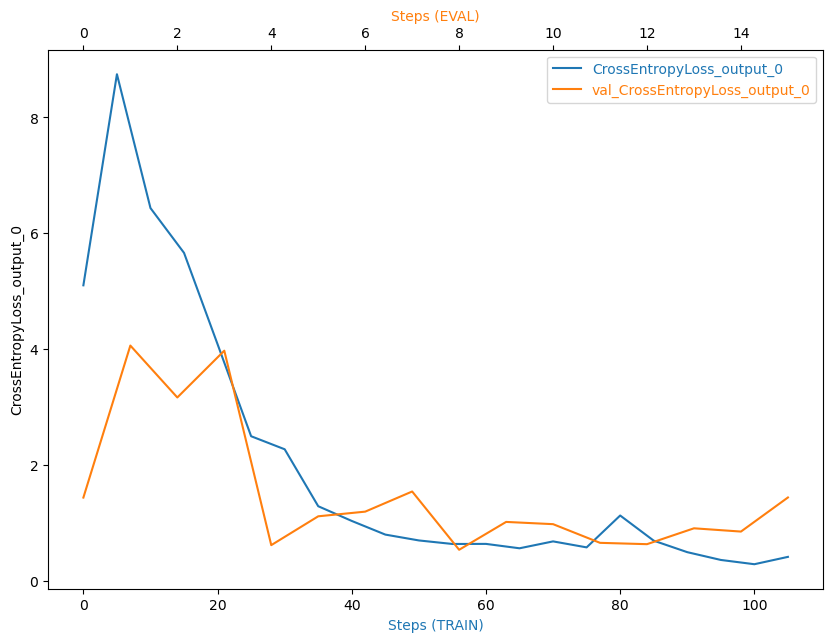

In [98]:
%matplotlib inline
plt_ten(trial, "CrossEntropyLoss_output_0")

In [126]:
# Display the profiler output
#some issues came out, but this will execute
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

AttributeError: 'PyTorchModel' object has no attribute 'output_path'

In [100]:
! aws s3 ls {rule_output_path} --recursive

2024-09-21 18:54:55     375140 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-09-21 18:54:55     223071 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-09-21 18:54:49        192 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-09-21 18:54:49        200 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-09-21 18:54:49       1883 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-09-21 18:54:49        127 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-09-21 18:54:49        199 pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-re

In [101]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/rul

## Model Deploying

In [149]:
model_location=estimator.model_data
# model_location = "s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/output/model.tar.gz"
print(model_location)

s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/output/model.tar.gz


In [150]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='train_model.py',
                             py_version='py36',
                             framework_version='1.8')

In [151]:
# This command takes long time to execute - it creates an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-476045913561/pytorch-training-2024-09-21-18-30-14-961/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-476045913561/pytorch-inference-2024-09-21-20-41-31-096/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-09-21-20-41-36-654
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-09-21-20-41-37-468
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-09-21-20-41-37-468


------!

In [152]:
predictor.serializer = IdentitySerializer("image/jpeg")

In [177]:
image_path = "./dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00734.jpg"

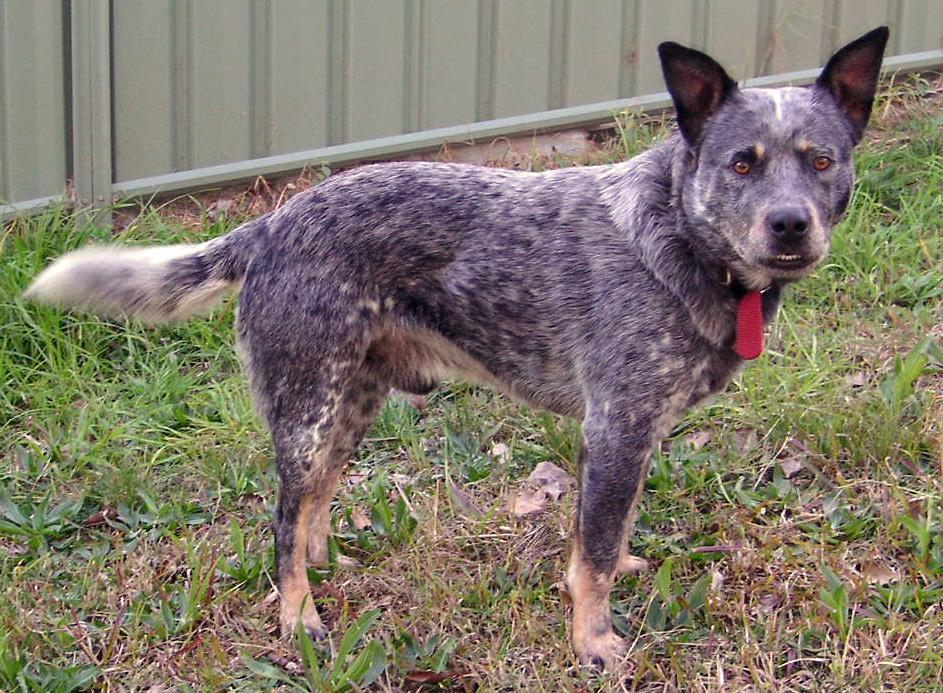

In [178]:
ImageDisplay(image)

In [181]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-09-21-20-41-37-468
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-09-21-20-41-37-468
